In [1]:
import os
import requests
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset
from transformers import AutoTokenizer
from datasets import load_dataset
import transformers
from peft import get_peft_model, PrefixTuningConfig, TaskType
from transformers import Trainer, TrainingArguments
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
import re

In [2]:
import json
from PIL import Image


# 假设你的 JSON 文件名为 data.json
with open("/root/IC_MLLM_VQA/Score/train_with_score_1_6.json", "r", encoding="utf-8") as f:
    dataset_train = json.load(f)

Question: Which animal's feet are also adapted for grabbing prey?
Choices: ['red-tailed hawk', 'pronghorn']
Hint: Bald eagles eat fish, mammals, and other birds. The 's feet are adapted for grabbing prey.
Figure: bald eagle.
Grade: grade3
Answer: 0
Explanation: The solution and lecture are :Look at the picture of the bald eagle.
The bald eagle has long toes with sharp claws. Its feet are adapted for grabbing prey. The sharp claws can help the bald eagle attack and kill its prey. The long toes can help it hold on to its prey.
Now look at each animal. Figure out which animal has a similar adaptation.
The red-tailed hawk has long toes with sharp claws. Its feet are adapted for grabbing prey.
The pronghorn has hoofed feet. Its feet are not adapted for grabbing prey. The pronghorn uses its feet to walk and run on hard ground.

An adaptation is an inherited trait that helps an organism survive or reproduce. Adaptations can include both body parts and behaviors.
The shape of an animal's feet 

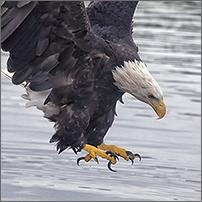

In [3]:
from random import choice

sample_1 = choice(dataset_train)
print(f"Question: {sample_1['question']}")
print(f"Choices: {sample_1['choices']}")
print(f"Hint: {sample_1['hint']}")
print(f"Grade: {sample_1['grade']}")
print(f"Answer: {sample_1['answer']}")
print(f"Explanation: {sample_1['solution_lecture']}")
print(f"Image type: {type(sample_1['image'])}")
image_path = '/root/IC_MLLM_VQA/Score/' + sample_1['image']
print(f"Image path: {image_path}")
img = Image.open(image_path)
img.show()


In [4]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class QwenVLPrefixDataset(Dataset):
    def __init__(self, data_list, processor, debug=False):
        self.data_list = data_list
        self.processor = processor
        self.debug = debug

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        sample = self.data_list[idx]
        return self.build_training_sample(sample)

    def build_training_sample(self, sample):
        # 1. 构造答案
        if isinstance(sample["answer"], int):
            answer_index = sample["answer"]
        else:
            answer_index = sample["choices"].index(sample["answer"])
        answer_letter = chr(65 + answer_index)

        # 2. 构建问题内容
        question_text = f"Question: {sample['question']}\nChoices:\n"
        for idx, choice in enumerate(sample["choices"]):
            question_text += f"{chr(65 + idx)}. {choice}\n"
        if sample.get("hint"):
            question_text += f"\nHint: {sample['hint']}\n"
        question_text += (
            "\nHere is a image:\n"
            "Please select the correct answer. Then, explain your reasoning in detail. "
            "Make sure your explanation is at least three sentences long, "
            "refers to specific data from the image, and shows your step-by-step logic."
        )

        # 3. 构建 label 文本（拼接到 prompt 后）
        label_text = f"\nAnswer: {answer_letter}\nExplanation: {sample['solution_lecture']}"

        # 4. 图像处理
        image_path = os.path.join("/root/IC_MLLM_VQA/Score", sample["image"])  # 用 join 更安全
        image = Image.open(image_path)  # 这里才是 PIL.Image.Image 类型
        image = image.convert("RGB").resize((224, 224))

        # 5. 构造完整对话 + 图像输入
        chat = [
            {"role": "user", "content": [
                {"type": "text", "text": question_text},
                {"type": "image", "image": image}
            ]},
            {"role": "assistant", "content": label_text}
        ]

        # 6. 编码图文输入（注意：一体编码 prompt+label）
        text = self.processor.apply_chat_template(chat, tokenize=False, add_generation_prompt=False)
        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="pt",
            padding=False,
            truncation=False
        )

        # 7. 构造 labels —— 用 input_ids 克隆，并 mask 掉前面的 prompt
        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)

        # 找到 label 的起始位置：用 processor 再只 encode user 部分计算长度
        user_text_only = self.processor.apply_chat_template(chat[:1], tokenize=False, add_generation_prompt=False)
        user_input_ids = self.processor.tokenizer(user_text_only, return_tensors="pt", add_special_tokens=False)["input_ids"][0]
        user_len = user_input_ids.shape[-1]

        labels = input_ids.clone()
        labels[:user_len] = -100  # mask prompt 部分
        
        score_str = sample.get('model_score', '0.0')  # 从原字段中取出字符串
        match = re.search(r"[\d.]+", score_str)
        score = float(match.group()) if match else 0.0

        result = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "pixel_values": inputs["pixel_values"].squeeze(0),
            'score': score # 添加分数字段
        }

        if "image_grid_thw" in inputs:
            result["image_grid_thw"] = inputs["image_grid_thw"].squeeze(0)

        if self.debug:
            print(f"[DEBUG] input_ids.shape: {input_ids.shape}")
            print(f"[DEBUG] labels.shape: {labels.shape}")

        return result


In [5]:
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")
train_dataset_score = QwenVLPrefixDataset(dataset_train, processor, debug=False)
print(f"Dataset length: {len(train_dataset_score)}")

# 检查数据集中的第一个样本
sample = train_dataset_score[0]
print(sample['score'])

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Dataset length: 4349
0.7


In [6]:
from transformers import AutoProcessor
from torch.utils.data import DataLoader

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")
train_dataset = QwenVLPrefixDataset(dataset_train, processor, debug=False)
dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True)

In [7]:
import torch
from torch.nn.utils.rnn import pad_sequence

def qwen_vl_collate_fn(batch):
    """
    Collate 函数，用于 QwenVL 多模态模型训练。
    自动对 input_ids / labels 进行 padding，
    pixel_values 和 image_grid_thw 直接 stack（假设 shape 一致）。
    """
    def pad_tensor_list(tensor_list, pad_value=0):
        return pad_sequence(tensor_list, batch_first=True, padding_value=pad_value)

    input_ids = [item["input_ids"] for item in batch]
    attention_mask = [item["attention_mask"] for item in batch]
    labels = [item["labels"] for item in batch]
    score = [item["score"] for item in batch]  # 添加分数字段

    # 部分模型 forward 需要 attention_mask，尽管有些模型不强依赖，也建议保留
    input_ids = pad_tensor_list(input_ids, pad_value=0)
    attention_mask = pad_tensor_list(attention_mask, pad_value=0)
    labels = pad_tensor_list(labels, pad_value=-100)  # 避免 loss 对 pad token 计算

    # 多模态部分
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    
    # 可选：容错处理 image_grid_thw（有些模型可能没有）
    if "image_grid_thw" in batch[0]:
        image_grid_thw = torch.stack([item["image_grid_thw"] for item in batch])
    else:
        image_grid_thw = None

    # 构造返回字典
    result = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
        "pixel_values": pixel_values,
        'score':torch.tensor(score, dtype=torch.float32)
        
    }
    # print(f"input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}, labels shape: {labels.shape}, pixel_values shape: {pixel_values.shape}")
    if image_grid_thw is not None:
        result["image_grid_thw"] = image_grid_thw

    return result


In [8]:
from torch.utils.data import DataLoader

# 正确使用 collate_fn
dataloader = DataLoader(train_dataset_score, batch_size=1, shuffle=False, collate_fn=qwen_vl_collate_fn)

# 获取第一个 batch
first_batch = next(iter(dataloader))

# 查看第一个样本的结构
n = 0
print("==== 第一个 batch 的第一个样本 ====")
print(f"input_ids shape: {first_batch['input_ids'][n].shape}")
print(f"attention_mask shape: {first_batch['attention_mask'][0].shape}")
print(f"labels shape: {first_batch['labels'][n].shape}")
print(f"pixel_values shape: {first_batch['pixel_values'][n].shape}")
print(f"image_grid_thw shape: {first_batch['image_grid_thw'][n].shape}")
print(f"score: {first_batch['score'][n]}")

# 可选：查看文本内容（需要 tokenizer）
tokenizer = processor.tokenizer
decoded_input = tokenizer.decode(first_batch['input_ids'][n], skip_special_tokens=True)
decoded_label = tokenizer.decode(
    [id for id in first_batch['labels'][n].tolist() if id != -100],
    skip_special_tokens=True
)

print("\n--- 解码后的 input_ids ---")
print(decoded_input)

print("\n--- 解码后的 labels ---")
print(decoded_label)


==== 第一个 batch 的第一个样本 ====
input_ids shape: torch.Size([276])
attention_mask shape: torch.Size([276])
labels shape: torch.Size([276])
pixel_values shape: torch.Size([256, 1176])
image_grid_thw shape: torch.Size([3])
score: 0.699999988079071

--- 解码后的 input_ids ---
system
You are a helpful assistant.
user
Question: Which of these states is farthest north?
Choices:
A. West Virginia
B. Louisiana
C. Arizona
D. Oklahoma

Here is a image:
Please select the correct answer. Then, explain your reasoning in detail. Make sure your explanation is at least three sentences long, refers to specific data from the image, and shows your step-by-step logic.
assistant

Answer: A
Explanation: The solution and lecture are :To find the answer, look at the compass rose. Look at which way the north arrow is pointing. West Virginia is farthest north.

Maps have four cardinal directions, or main directions. Those directions are north, south, east, and west.
A compass rose is a set of arrows that point to the car

In [9]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct", device_map="auto", torch_dtype=torch.bfloat16
)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
from peft import LoraConfig, get_peft_model, TaskType

peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,  # 对于 Qwen 这类生成模型，使用 CAUSAL_LM
    inference_mode=False,          # 表示用于训练，不是推理
    r=8,                           # LoRA 秩，越大可训练参数越多（常见：4, 8, 16）
    lora_alpha=32,                 # 缩放因子，通常与 r 同阶或更大
    lora_dropout=0.1,              # dropout，防止过拟合
    target_modules=["q_proj", "v_proj"]
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


trainable params: 2,523,136 || all params: 8,294,689,792 || trainable%: 0.0304


In [11]:
from transformers import Trainer
import torch
import torch.nn as nn

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # 容错删除不需要的参数
        kwargs.pop("num_items_in_batch", None)

        labels = inputs.pop("labels")
        scores = inputs.pop("score")  # 已经是 tensor（来自 collate_fn）

        # 前向传播
        outputs = model(**inputs)
        logits = outputs.logits

        # CrossEntropyLoss with token-level reduction
        loss_fct = nn.CrossEntropyLoss(ignore_index=-100, reduction='none')
        token_loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
        token_loss = token_loss.view(labels.size(0), -1)  # (batch, seq_len)
        sample_loss = token_loss.mean(dim=1)              # (batch,)

        # ✅ 保证 score tensor 在同一 device 上
        scores = scores.to(sample_loss.device)
        penalty = 1.0 - scores
        weighted_loss = (penalty * sample_loss).mean()

        return (weighted_loss, outputs) if return_outputs else weighted_loss




In [12]:
import re
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge

def parse_output(output: str):
    """
    提取选择题答案和解释文本，容错支持 Answer: A, A., A: 等。
    返回 answer: int (0~3 对应 A-D), explanation: str
    """
    output = output.strip()
    answer_match = re.search(r"(?i)\banswer\s*[:\-]?\s*([A-D])\b", output)
    if not answer_match:
        answer_match = re.search(r"\b([A-D])[\.\:\-]", output)

    if answer_match:
        choice_char = answer_match.group(1).upper()
        answer = ord(choice_char) - ord("A")
    else:
        answer = -1

    explanation = ""
    if answer_match:
        idx = output.find(answer_match.group(0))
        if idx != -1:
            explanation = output[idx + len(answer_match.group(0)):].strip()

    return answer, explanation

def keyword_overlap(pred, ref):
    pred_keywords = set(pred.lower().split())
    ref_keywords = set(ref.lower().split())
    if not ref_keywords:
        return 0.0
    return len(pred_keywords & ref_keywords) / len(ref_keywords)

def compute_metrics(eval_preds, tokenizer):
    predictions = eval_preds.predictions
    label_ids = eval_preds.label_ids

    # 如果 predictions 是 tuple（例如包含 logits），取第一个作为 token ids
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # 如果是 logits（形如 [batch, seq_len, vocab_size]），则 argmax 得到 token ids
    if predictions.ndim == 3:
        predictions = predictions.argmax(-1)

    decoded_preds = []
    decoded_labels = []

    for pred_ids, label in zip(predictions, label_ids):
        label = [id for id in label if id != -100]
        decoded_pred = tokenizer.decode(pred_ids, skip_special_tokens=True)
        decoded_label = tokenizer.decode(label, skip_special_tokens=True)

        decoded_preds.append(decoded_pred.strip())
        decoded_labels.append(decoded_label.strip())

    # 打印第一个样本的预测和标签
    print("\n==== 示例输出 ====")
    print("预测：", decoded_preds[0])
    print("标签：", decoded_labels[0])

    smoothie = SmoothingFunction().method4
    bleu1_scores = []
    bleu4_scores = []
    rouge_l_scores = []
    keyword_overlaps = []
    choice_correct = []

    rouge = Rouge()

    for pred, label in zip(decoded_preds, decoded_labels):
        reference = label.split()
        candidate = pred.split()

        # BLEU-1 和 BLEU-4
        bleu1 = sentence_bleu([reference], candidate, weights=(1, 0, 0, 0), smoothing_function=smoothie)
        bleu4 = sentence_bleu([reference], candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
        bleu1_scores.append(bleu1)
        bleu4_scores.append(bleu4)

        # ROUGE-L
        try:
            rouge_l = rouge.get_scores(pred, label)[0]['rouge-l']['f']
        except ValueError:
            rouge_l = 0.0
        rouge_l_scores.append(rouge_l)

        # Keyword overlap
        keyword_acc = keyword_overlap(pred, label)
        keyword_overlaps.append(keyword_acc)

        # Choice accuracy
        pred_choice, _ = parse_output(pred)
        label_choice, _ = parse_output(label)
        is_correct = (pred_choice == label_choice) and (pred_choice != -1)
        choice_correct.append(int(is_correct))

    return {
        "BLEU-1": np.mean(bleu1_scores),
        "BLEU-4": np.mean(bleu4_scores),
        "ROUGE-L": np.mean(rouge_l_scores),
        "KeywordOverlap": np.mean(keyword_overlaps),
        "ChoiceAccuracy": np.mean(choice_correct),
    }



In [13]:
from transformers import AutoProcessor
from torch.utils.data import DataLoader

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")
train_dataset = QwenVLPrefixDataset(dataset_train, processor, debug=False)
dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True)

In [14]:
from transformers import Trainer, TrainingArguments
import torch



training_args = TrainingArguments(
    output_dir="./qwen2.5vl-Lora1-6",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=1, 
    dataloader_num_workers=0,
    eval_accumulation_steps=1,
    learning_rate=5e-4,
    num_train_epochs=50,
    logging_steps=10,
    save_steps=500,
    save_total_limit=2,
    bf16=True,  # 如果使用的是支持 bfloat16 的 GPU，可改为 bf16=True
    gradient_accumulation_steps=4,
    remove_unused_columns=False

)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    # eval_dataset=val_dataset,
    data_collator=qwen_vl_collate_fn,
    compute_metrics=lambda p: compute_metrics(p, tokenizer=processor.tokenizer)
)


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
[codecarbon ERROR @ 20:22:33] Error: Another instance of codecarbon is probably running as we find `/tmp/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.


In [15]:
trainer.train()

[codecarbon WARNING @ 20:22:33] Another instance of codecarbon is already running. Exiting.


Step,Training Loss


KeyboardInterrupt: 

In [ ]:
metrics = trainer.evaluate()
print(metrics)

In [ ]:
trainer.save_model("./qwen2.5vl-Lora1-6/final")   